In [19]:
import os

root_path = "dataset"

def count_files(path):
    return len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]) if os.path.exists(path) else 0

summary = []

for mode in ["Training", "Testing"]:
    mode_path = os.path.join(root_path, mode)
    if os.path.isdir(mode_path):
        for category in os.listdir(mode_path):
            category_path = os.path.join(mode_path, category)
            if os.path.isdir(category_path):
                file_count = count_files(category_path)
                summary.append(f"{mode}/{category} -> {file_count} files")

for line in summary:
    print(line)

Training/Fresh_Gills -> 613 files
Training/Nonfresh_Eyes -> 1028 files
Training/Fresh_Eyes -> 233 files
Training/Nonfresh_Gills -> 1265 files
Testing/Fresh_Gills -> 80 files
Testing/Nonfresh_Eyes -> 257 files
Testing/Fresh_Eyes -> 134 files
Testing/Nonfresh_Gills -> 316 files


In [20]:
#  Import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [21]:
# Verifikasi apakah GPU tersedia
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [22]:
import tensorflow as tf

# Verifikasi GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("GPU tidak ditemukan, menggunakan CPU.")
else:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Menggunakan GPU.")

Menggunakan GPU.


In [23]:
#  Load dataset dari folder
batch_size = 32
img_size = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/Training",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/Testing",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False  # Penting untuk evaluasi
)

class_names = train_ds.class_names
print("Class names:", class_names)

Found 3139 files belonging to 4 classes.
Found 787 files belonging to 4 classes.
Class names: ['Fresh_Eyes', 'Fresh_Gills', 'Nonfresh_Eyes', 'Nonfresh_Gills']


In [24]:
#  Tambahkan augmentasi data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [25]:
# Preprocessing untuk EfficientNetV2
def preprocess(image, label):
    image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
    return image, label

In [26]:
# Terapkan augmentasi hanya ke training
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [27]:
#  Hitung class weight agar adil untuk data tidak seimbang
base_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet",
    pooling='avg'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [28]:
# Bangun model klasifikasi
base_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet",
    pooling='avg'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [29]:
# Latih model
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 73s 602ms/step - accuracy: 0.6260 - loss: 0.9278 - precision: 0.7590 - recall: 0.4058 - val_accuracy: 0.9403 - val_loss: 0.4693 - val_precision: 0.9634 - val_recall: 0.9034 - learning_rate: 0.0010
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 75s 752ms/step - accuracy: 0.9348 - loss: 0.2775 - precision: 0.9454 - recall: 0.9146 - val_accuracy: 0.9327 - val_loss: 0.3934 - val_precision: 0.9445 - val_recall: 0.9085 - learning_rate: 0.0010
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9635 - loss: 0.1908 - precision: 0.9671 - recall: 0.9551 - val_accuracy: 0.9695 - val_loss: 0.2951 - val_precision: 0.9804 - val_recall: 0.9555 - learning_rate: 0.0010
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9744 - loss: 0.1438 - precision: 0.9792 - recall: 0.9694 - val_accuracy: 0.9936 - val_loss: 0.2095 - val_precision: 0.9961 - val_recall: 0.9835 - learning_rate: 0.0010
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0

2025-05-14 17:51:33.435034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 982ms/step

Classification Report:
                precision    recall  f1-score   support

    Fresh_Eyes       0.82      1.00      0.90       134
   Fresh_Gills       1.00      1.00      1.00        80
 Nonfresh_Eyes       1.00      0.89      0.94       257
Nonfresh_Gills       1.00      1.00      1.00       316

      accuracy                           0.96       787
     macro avg       0.96      0.97      0.96       787
  weighted avg       0.97      0.96      0.96       787



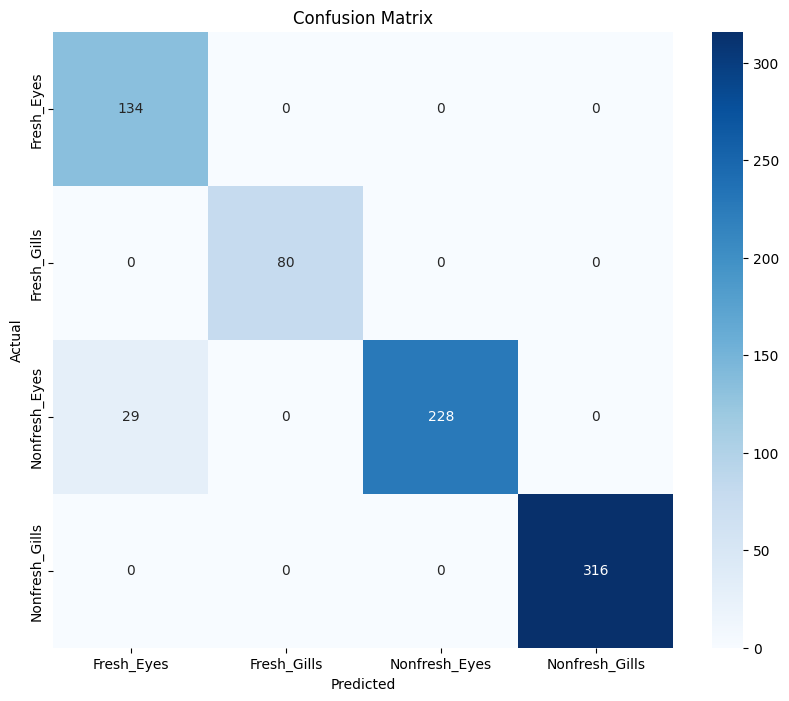

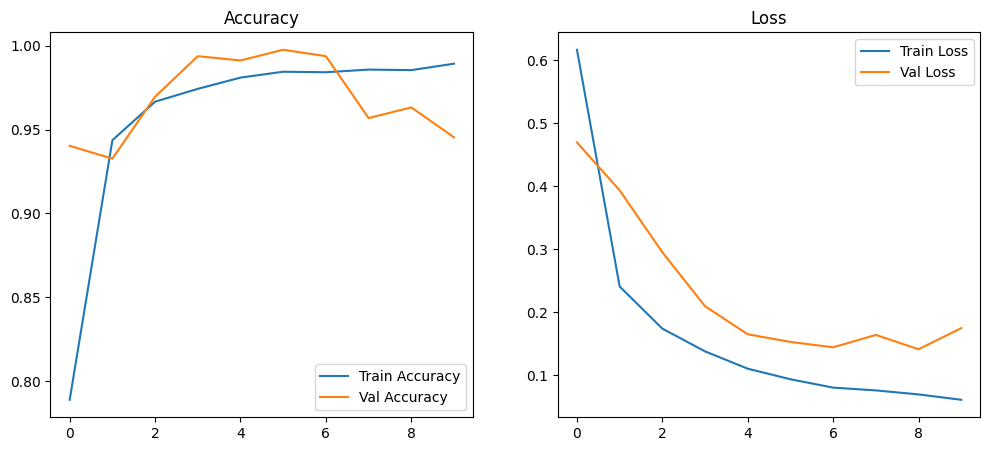

In [30]:
#  Visualisasi Akurasi dan Evaluasi Model
y_true = np.concatenate([np.argmax(y, axis=1) for x, y in val_ds], axis=0)
y_pred = np.argmax(model.predict(val_ds), axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()